In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
from itertools import combinations
import statsmodels.api as sm

plt.rcParams['font.family'] = 'AppleGothic'
plt.rc('axes',unicode_minus=False)

In [221]:
df = pd.read_csv('../datasets/unlisted_resampled_train_data.csv')

In [222]:
df.columns

Index(['회사명', '거래소코드', '회계년도', 'CASH FLOW 대 부채비율', 'CASH FLOW 대 차입금비율',
       'CASH FLOW 대 총자본비율', 'CASH FLOW 대 매출액비율', '유동비율', '당좌비율', '부채비율',
       '유동부채비율', '차입금의존도', '순운전자본비율', '현금비율', '유동자산구성비율', '자기자본구성비율',
       '자기자본순이익률', '경영자본순이익률', '매출액순이익률', '총자본사업이익률', '총자본영업이익률', '매출액영업이익률',
       '금융비용부담률', 'CROE', '총자산증가율', '총자본증가율', '유동자산증가율', '비유동자산증가율', '매출액증가율',
       '유형자산증가율', '부가가치', '총자본투자효율', '설비투자효율', '부가가치율', '이윤분배율', '자본분배율',
       '총자산회전율', '매출채권회전률', '당좌자산회전률', '유형자산회전율', '경영자본회전률', '총자본회전률',
       '비유동자산회전률', '유동자산회전률', '영업년수', '쭈피처', '영업투자현금비율', '영업재무현금비율', '도입기',
       '성숙기', '성장기', '쇠퇴기', '부실판단'],
      dtype='object')

In [223]:
df.isna().sum()

회사명                  0
거래소코드                0
회계년도                 0
CASH FLOW 대 부채비율     0
CASH FLOW 대 차입금비율    0
CASH FLOW 대 총자본비율    0
CASH FLOW 대 매출액비율    0
유동비율                 0
당좌비율                 0
부채비율                 0
유동부채비율               0
차입금의존도               0
순운전자본비율              0
현금비율                 0
유동자산구성비율             0
자기자본구성비율             0
자기자본순이익률             0
경영자본순이익률             0
매출액순이익률              0
총자본사업이익률             0
총자본영업이익률             0
매출액영업이익률             0
금융비용부담률              0
CROE                 0
총자산증가율               0
총자본증가율               0
유동자산증가율              0
비유동자산증가율             0
매출액증가율               0
유형자산증가율              0
부가가치                 0
총자본투자효율              0
설비투자효율               0
부가가치율                0
이윤분배율                0
자본분배율                0
총자산회전율               0
매출채권회전률              0
당좌자산회전률              0
유형자산회전율              0
경영자본회전률              0
총자본회전률               0
비유동자산회전률             0
유동자산회전률    

In [224]:
df = df.drop(columns=['회사명', '거래소코드', '회계년도', '도입기', '성숙기', '성장기', '쇠퇴기'])

In [225]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val = bartlett(df[df['부실판단']==1][i], df[df['부실판단']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [226]:
# 이분산성 변수
x_hetero = bartlett_test(df.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test(df.columns, H = 0)

In [227]:
# t-test

import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [228]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(df.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest = x_ttest.sort_values(by="변수", ascending=True).reset_index(drop=True)
x_ttest

유의한 피쳐 수 : 33


,변수,p_value
0,CASH FLOW 대 매출액비율,1.989309e-43
1,CASH FLOW 대 부채비율,2.757746e-87
2,CASH FLOW 대 차입금비율,5.046135e-11
3,CASH FLOW 대 총자본비율,2.019508e-111
4,CROE,1.354156e-02
5,경영자본순이익률,6.765694e-133
6,경영자본회전률,3.913749e-83
7,금융비용부담률,1.011605e-49
8,매출액순이익률,1.424303e-16
9,매출액영업이익률,8.905963e-42


In [229]:
ttest_list = list(x_ttest['변수'])

In [230]:
ttest_df = df[ttest_list]

In [231]:
ttest_df

,CASH FLOW 대 매출액비율,CASH FLOW 대 부채비율,CASH FLOW 대 차입금비율,CASH FLOW 대 총자본비율,CROE,경영자본순이익률,경영자본회전률,금융비용부담률,매출액순이익률,매출액영업이익률,...,자기자본순이익률,자본분배율,쭈피처,차입금의존도,총자본사업이익률,총자본영업이익률,총자본투자효율,총자본회전률,총자산회전율,현금비율
0,-29.60,-13.39,-18.27,-8.78,-0.422430,-25.27,0.34,5.28,-74.84,-72.71,...,-78.23,0.0000,0.339051,48.05,-24.23,-24.24,-12.59,0.33,0.296510,7.64
1,-9.86,-2.22,-2.46,-2.09,0.904542,3.67,0.22,14.03,16.85,31.22,...,92.09,82.0000,0.249527,85.18,6.80,6.79,11.77,0.22,0.212196,1.25
2,0.37,1.21,9.00,1.14,1.829821,2.15,2.47,0.06,0.87,0.56,...,62.09,37.8000,0.076154,12.67,1.60,1.38,11.03,2.46,3.123103,0.06
3,-2.24,-13.36,-21.97,-7.20,-0.127393,2.03,3.46,0.23,0.59,1.19,...,4.17,43.6700,0.021831,32.78,4.32,4.10,8.24,3.46,3.219526,15.76
4,9.19,8.41,9.03,7.67,-1.061291,-15.25,0.88,1.71,-17.27,-15.84,...,-91.42,-382.3706,0.104760,84.99,-12.66,-12.68,0.43,0.80,0.835089,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8597,-1.38,-0.09,-0.91,-0.09,-0.893985,-1.60,0.07,3.91,-22.88,-20.65,...,-72.63,41.1100,0.358294,9.63,-1.08,-1.33,1.39,0.06,0.063712,676.51
8598,0.06,0.05,0.06,0.04,-0.311638,-11.61,0.80,3.01,-14.42,-15.02,...,-70.00,-16.0500,0.271245,75.02,-11.10,-11.18,9.07,0.74,0.780117,4.83
8599,-17.89,-22.53,-718.30,-16.24,-0.266998,-12.56,0.79,-0.41,-15.87,-16.70,...,-41.04,0.0000,0.071507,2.26,-12.88,-13.21,-14.11,0.79,0.908018,3.26
8600,-5.23,-2.16,-2.27,-2.29,17.197040,-7.96,0.30,4.94,-26.65,-36.14,...,0.00,43.6400,0.245398,100.98,-10.10,-10.14,12.00,0.28,0.438701,4.36


### Wrapper 피처 셀렉션

In [232]:
wrapper_df = df

In [233]:
# 학습 데이터와 검증 데이터 분리
X_train = wrapper_df.drop(columns='부실판단')
y_train = wrapper_df['부실판단']

#### 스케일링

In [234]:
labels = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns = labels)

In [235]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [236]:
sbs = SFS(LinearRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
li_backward_feature_list = sbs.k_feature_names_

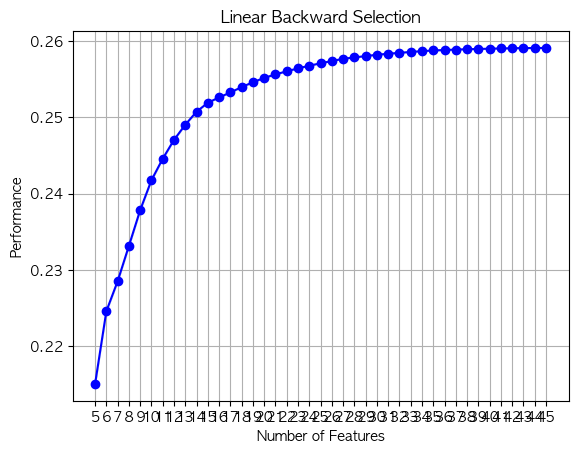

In [237]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Linear Backward Selection')
plt.grid()
plt.show()

In [265]:
li_backward_feature = list(li_backward_feature_list)
li_backward_feature_final_list = li_backward_feature[0:14]

In [239]:
#Sequential backward selection(sbs)
sbs = SFS(LogisticRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
logit_backward_feature_list = sbs.k_feature_names_

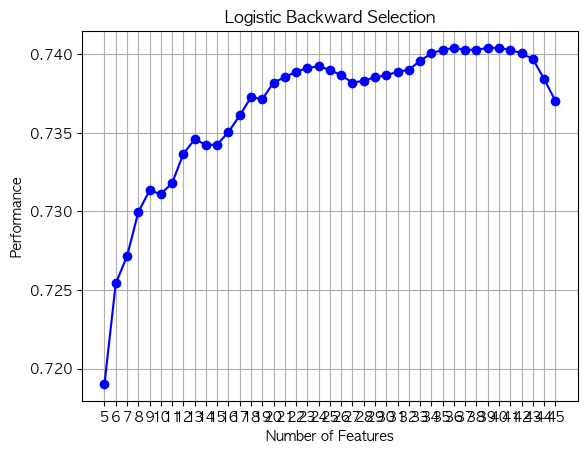

In [240]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Logistic Backward Selection')
plt.grid()
plt.show()

In [264]:
logit_backward_feature = list(logit_backward_feature_list)
logit_backward_feature_final_list = logit_backward_feature[0:12]

In [242]:
#Sequential backward selection(sbs)
sbs = SFS(RandomForestClassifier(max_depth=5),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
RF_backward_feature_list = sbs.k_feature_names_

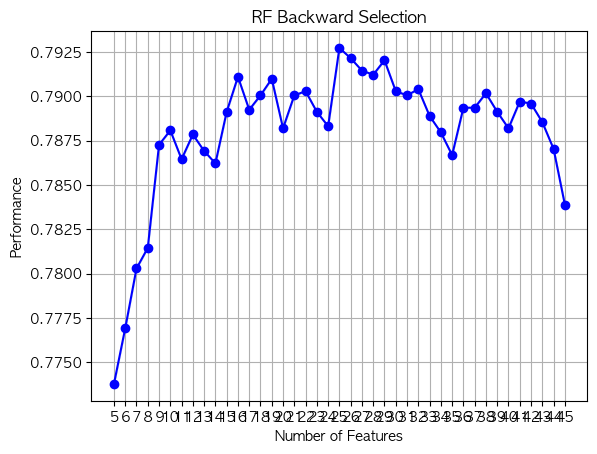

In [243]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('RF Backward Selection')
plt.grid()
plt.show()

In [263]:
RF_backward_feature = list(RF_backward_feature_list)
RF_backward_feature_final_list = RF_backward_feature[0:9]

In [266]:
def func_Linear_Backward(x):
    if x in li_backward_feature_final_list:
        return 1
    else:
        return 0

def func_Logit_Backward(x):
    if x in logit_backward_feature_final_list:
        return 1
    else:
        return 0
    
def func_RF_Backward(x):
    if x in RF_backward_feature_final_list:
        return 1
    else:
        return 0

In [267]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Linear Backward'] = list_col_all.map(func_Linear_Backward)
feature_counts['Logit Backward'] = list_col_all.map(func_Logit_Backward)
feature_counts['RF Backward'] = list_col_all.map(func_RF_Backward)

feature_counts["Backward Total"] = feature_counts['Linear Backward'] + feature_counts['Logit Backward'] + feature_counts['RF Backward']

backward_feature_final = feature_counts[feature_counts["Backward Total"]>=2]
list_feature_final = list(backward_feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
backward_feature_final

선택된 피쳐수 : 11


,Feature,Linear Backward,Logit Backward,RF Backward,Backward Total
2,CASH FLOW 대 총자본비율,1,0,1,2
3,CASH FLOW 대 매출액비율,1,0,1,2
9,순운전자본비율,1,0,1,2
12,자기자본구성비율,1,1,1,3
14,경영자본순이익률,1,1,1,3
16,총자본사업이익률,1,1,0,2
17,총자본영업이익률,1,1,1,3
19,금융비용부담률,1,1,0,2
25,매출액증가율,1,1,0,2
31,이윤분배율,1,1,0,2


In [268]:
backward_feature = list(backward_feature_final['Feature'])
backward_feature

['CASH FLOW 대 총자본비율',
 'CASH FLOW 대 매출액비율',
 '순운전자본비율',
 '자기자본구성비율',
 '경영자본순이익률',
 '총자본사업이익률',
 '총자본영업이익률',
 '금융비용부담률',
 '매출액증가율',
 '이윤분배율',
 '비유동자산회전률']

### Embedded : Lasso

In [282]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha= 0.045, max_iter = 10000).fit(X_train, y_train)
feature_list = lasso.feature_names_in_[lasso.coef_ != 0]

lasso_feature_list = feature_list
len(lasso_feature_list)

10

### Ttest, Backward, Lasso 중첩 feature 확인

In [283]:
def func_Ttest(x):
    if x in ttest_list:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in backward_feature:
        return 1
    else:
        return 0
    
def func_lasso(x):
    if x in lasso_feature_list:
        return 1
    else:
        return 0

In [284]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Ttest'] = list_col_all.map(func_Ttest)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Lasso'] = list_col_all.map(func_lasso)

feature_counts["Total"] = feature_counts["Ttest"]+feature_counts['Backward']+feature_counts["Lasso"]

feature_final = feature_counts[feature_counts["Total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 14


,Feature,Ttest,Backward,Lasso,Total
0,CASH FLOW 대 부채비율,1,0,1,2
2,CASH FLOW 대 총자본비율,1,1,1,3
3,CASH FLOW 대 매출액비율,1,1,0,2
8,차입금의존도,1,0,1,2
9,순운전자본비율,1,1,1,3
12,자기자본구성비율,1,1,1,3
14,경영자본순이익률,1,1,1,3
16,총자본사업이익률,1,1,0,2
17,총자본영업이익률,1,1,1,3
19,금융비용부담률,1,1,0,2
